# Setup

In [1]:
# Define Parameters
batch_size = 32
epochs = 5
# task = 'Damage_Severity_Classification'
# task = 'Disaster_Types_Classification'
task = 'Humanitarian_Classification'
# task = 'Informativeness_Classification'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.functional import InterpolationMode
from torch.nn.parallel import DataParallel
from tqdm import tqdm

warnings.filterwarnings("ignore")
device = torch.device("cuda")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    parallel = True
else:
    parallel = False

# Data Loading

In [3]:
# Damage Severity
# train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_train_final.tsv'
# test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_test_final.tsv'
# dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_dev_final.tsv'

# Disaster Types
# train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_train_final.tsv'
# test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_test_final.tsv'
# dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_dev_final.tsv'

# Humanitarian
train_path = 'C:/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_train_final.tsv'
test_path = 'C:/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_test_final.tsv'
dev_path = 'C:/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_dev_final.tsv'

# Informativeness
# train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_train_final.tsv'
# test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_test_final.tsv'
# dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_dev_final.tsv'

train_label = pd.read_table(train_path)
test_label = pd.read_table(test_path)
dev_label = pd.read_table(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(12618, 4)
(2922, 4)
(1229, 4)


In [5]:
# class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}
# class_label_map = {"landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0}
class_label_map = {"affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0}
# class_label_map = {"informative": 1, "not_informative": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((272, 272), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 12618/12618 [02:15<00:00, 93.07it/s] 


torch.Size([3, 256, 256])
(12618, 3, 256, 256)


100%|██████████| 12618/12618 [00:00<00:00, 435099.21it/s]


(12618,)


100%|██████████| 2922/2922 [00:32<00:00, 90.08it/s] 


torch.Size([3, 256, 256])
(2922, 3, 256, 256)


100%|██████████| 2922/2922 [00:00<00:00, 730552.95it/s]


(2922,)


 71%|███████   | 868/1229 [00:08<00:07, 50.27it/s] 

Error opening image: C:/crisis_vision_benchmarks/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/damaged_infrastructure/images/wreckedcar_2017-02-23_21-15-25.jpg - image file is truncated (0 bytes not processed)


100%|██████████| 1229/1229 [00:16<00:00, 73.37it/s]


torch.Size([3, 256, 256])
(1228, 3, 256, 256)


100%|██████████| 1228/1228 [00:00<00:00, 1226626.65it/s]

(1228,)


In [12]:
unique_classes = np.unique(y_dev)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 4
Unique classes: [0 1 2 3]


In [13]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# Model

In [14]:
model = models.swin_v2_b(weights = models.Swin_V2_B_Weights.DEFAULT)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, len(class_label_map))
model = DataParallel(model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.05)

warmup_epochs = 20
warmup_factor = 1.0 / warmup_epochs
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / warmup_epochs)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs, eta_min=0.00001)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

# Train

In [7]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [8]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_swintransformer.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [9]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(dev_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.4084 - accuracy: 24.98% - val_loss: 1.4073 - val_accuracy: 25.22% - time: 119.47s
Epoch 2/100 - loss: 1.1227 - accuracy: 56.37% - val_loss: 1.1210 - val_accuracy: 58.86% - time: 117.24s
Epoch 3/100 - loss: 1.1515 - accuracy: 54.34% - val_loss: 1.1222 - val_accuracy: 56.64% - time: 117.31s
Epoch 4/100 - loss: 1.1473 - accuracy: 55.22% - val_loss: 1.1327 - val_accuracy: 54.86% - time: 117.10s
Epoch 5/100 - loss: 1.1645 - accuracy: 52.73% - val_loss: 1.1069 - val_accuracy: 58.08% - time: 117.00s
Epoch 6/100 - loss: 1.1490 - accuracy: 54.49% - val_loss: 1.1110 - val_accuracy: 57.32% - time: 117.08s
Epoch 7/100 - loss: 1.1378 - accuracy: 56.17% - val_loss: 1.1292 - val_accuracy: 59.10% - time: 116.98s
Epoch 8/100 - loss: 1.1335 - accuracy: 56.19% - val_loss: 1.1306 - val_accuracy: 56.57% - time: 116.97s
Epoch 9/100 - loss: 1.1420 - accuracy: 55.48% - val_loss: 1.0906 - val_accuracy: 58.97% - time: 117.09s
Epoch 10/100 - loss: 1.1317 - accuracy: 56.58% - val_loss: 1.096

Epoch 80/100 - loss: 1.1033 - accuracy: 57.68% - val_loss: 1.0842 - val_accuracy: 59.14% - time: 116.73s
Epoch 81/100 - loss: 1.0966 - accuracy: 58.39% - val_loss: 1.0808 - val_accuracy: 59.45% - time: 117.06s
Epoch 82/100 - loss: 1.1033 - accuracy: 57.85% - val_loss: 1.0908 - val_accuracy: 58.04% - time: 116.73s
Epoch 83/100 - loss: 1.1003 - accuracy: 58.28% - val_loss: 1.1049 - val_accuracy: 58.52% - time: 117.02s
Epoch 84/100 - loss: 1.1126 - accuracy: 57.20% - val_loss: 1.1019 - val_accuracy: 56.61% - time: 116.70s
Epoch 85/100 - loss: 1.1052 - accuracy: 57.87% - val_loss: 1.0908 - val_accuracy: 58.90% - time: 117.12s
Epoch 86/100 - loss: 1.0993 - accuracy: 58.19% - val_loss: 1.0807 - val_accuracy: 59.82% - time: 117.10s
Epoch 87/100 - loss: 1.1027 - accuracy: 58.16% - val_loss: 1.0843 - val_accuracy: 59.34% - time: 117.04s
Epoch 88/100 - loss: 1.1067 - accuracy: 57.66% - val_loss: 1.0854 - val_accuracy: 58.56% - time: 117.12s
Epoch 89/100 - loss: 1.1067 - accuracy: 57.72% - val_lo

In [10]:
print(task + '_Swin Transformer Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_Swin Transformer Classification Report:')
print(cr)

Humanitarian_Classification_Swin Transformer Performance:
Accuracy : 60.38%
F1-Score : 54.06%
Humanitarian_Classification_Swin Transformer Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.86      0.71      1550
           1       0.51      0.46      0.48       821
           2       0.00      0.00      0.00       391
           3       0.00      0.00      0.00       160

    accuracy                           0.58      2922
   macro avg       0.28      0.33      0.30      2922
weighted avg       0.47      0.58      0.51      2922



# Visualize

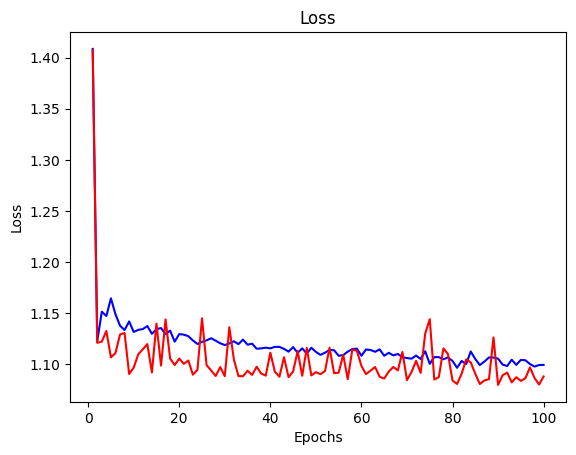

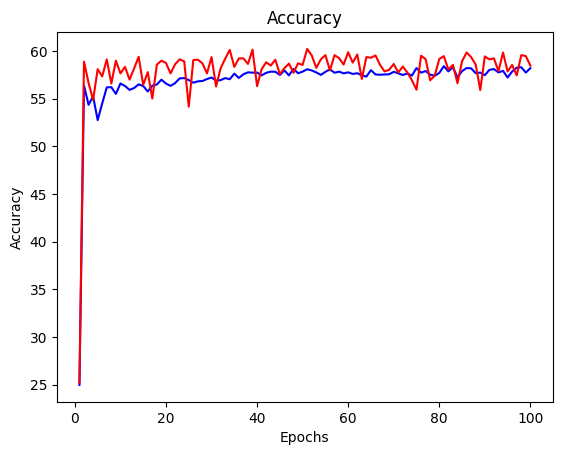

In [11]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_Swin Transformer Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


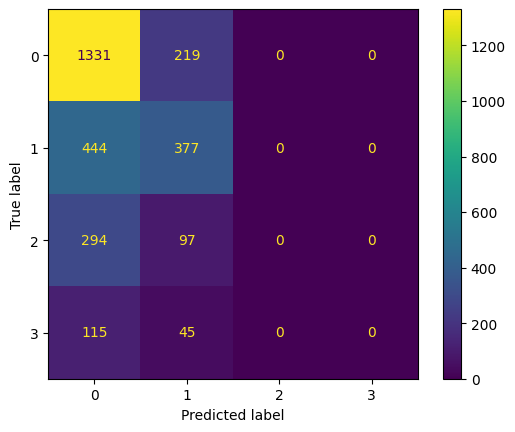

In [12]:
print(task + '_Swin Transformer Confusion Matrix:\n')
# print('severe: 2, mild: 1, little_or_none: 0')
# print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
print('affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0')
# print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()